<a href="https://colab.research.google.com/github/pds2122/course/blob/main/assignments/03_PA_DL_on_tabular_data_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 21/22*
# Programming Assignment 3 - Predicting Video Game Sales with Deep Learning

In this programming assignment, you need to apply your new deep learning knowledge. In contrast to PA2, you don't have to bother about feature engineering. You will build an artificial neural network with multiple layers that learns features from the raw data.

## Introduction and Dataset

You are provided with a dataset containing a list of video games with sales greater than 100.000 copies. Again, your task is to build a model predicting the yearly global sales (column ``Global_Sales``) of a video game leveraging the available features.

To help you get started, the following blocks of code import the dataset using pandas: 

In [ ]:
import pandas as pd

In [ ]:
data_path = 'https://raw.githubusercontent.com/NikoStein/pds_data/main/data/video_game_sales.csv'
df = pd.read_csv(data_path)
df.head()

,Name,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,82.53,76.0,51.0,8.0,322.0,E
1,Super Mario Bros.,NES,1985.0,Platform,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,32.77,80.0,73.0,8.0,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,NaN,NaN,NaN,NaN,NaN


## Creating Dataloaders

First, import everything we need for the tabular model

In [ ]:
!pip install -Uqq fastai  # upgrade fastai on colab
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 


To create [TabularDataLoaders](https://docs.fast.ai/tabular.data.html#TabularDataLoaders), you need to assign the variables to dependent, categorical and continuous variables

In [ ]:
# Write your code here
y_names = 'Global_Sales'
cat_names = ['Platform', 'Genre', 'Rating']
cont_names = ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']

fast.ai contains classes that define [transformations](https://docs.fast.ai/tabular.transform.html) for preprocessing. Provide a list of appropriate preprocessing steps.

In [ ]:
# Write your code here
procs = [FillMissing, Categorify, Normalize]

You also need to define the train and validation set (using indices!). 
- Use a train/test split of 80/20

In [ ]:
# Write your code here
train_idx, valid_idx = train_test_split(range(len(df)), test_size=0.2, random_state = 0)

Now you're ready to create the [TabularDataLoaders](https://docs.fast.ai/tabular.data.html#TabularDataLoaders) that you'll use for training.
- Use the Factory Method that creates the `dls` from a dataframe
- Set the batch size to 16

In [ ]:
dls = TabularDataLoaders.from_df(df=df, y_names=y_names, valid_idx=valid_idx, 
                                 procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 bs=64)

How many features numerical and categorical feautures are created by the dataloaders after preprocessing the data?
- print the names and the count of these features

In [ ]:
# Write your code here
print('Categorical feature names:', dls.cat_names)
print('Number of categorical features:', len(dls.cat_names))
print('Continuous feature names:', dls.cont_names)
print('Number of continuous features:', len(dls.cont_names))

Categorical feature names: ['Platform', 'Genre', 'Rating', 'Year_of_Release_na', 'Critic_Score_na', 'Critic_Count_na', 'User_Score_na', 'User_Count_na']
Number of categorical features: 8
Continuous feature names: ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']
Number of continuous features: 5


## Modeling

### Create Learner

Create an [appropriate learner](https://docs.fast.ai/tabular.learner.html) for data. A learner creates a neural network for us.
- Use 100 nodes in the first and 50 nodes in the second layer
- Choose the [metrics](https://docs.fast.ai/metrics.html) *root mean squared error* and mean *absolute error*. You can pass a list of metrics to the learner.
- Bonus: Looking at the keyword arguments of the [tabular learner](https://docs.fast.ai/tabular.learner.html), how could you limit the predicted sales appropriately?

In [ ]:
# Write your code here
# Limiting the output activation fixes instable training and leads to better results
range_scale = 1.2
y_range = (float(df.iloc[train_idx].Global_Sales.min() * range_scale),
           float(df.iloc[train_idx].Global_Sales.max() * range_scale))

learn = tabular_learner(dls, layers=[100,50], metrics=[rmse, mae], y_range=y_range)

How many Embeddings are there in the model? Use `learn.dls.show_batch()` to explain why!

In [ ]:
# Write your answer here
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(32, 11)
    (1): Embedding(13, 7)
    (2): Embedding(9, 5)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=43, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0.012, high=99.036)
  )
)

In [ ]:
learn.dls.show_batch()

,Platform,Genre,Rating,Year_of_Release_na,Critic_Score_na,Critic_Count_na,User_Score_na,User_Count_na,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count,Global_Sales
0,DS,Puzzle,E,False,True,True,False,True,2009.0,71.000000,21.000000,7.13,24.000003,0.10
1,DS,Adventure,T,False,False,False,False,False,2005.0,70.000000,51.000001,8.10,42.000000,0.29
2,GBA,Sports,E,False,False,False,False,False,2004.0,34.999999,7.000000,8.00,7.000003,0.03
3,Wii,Role-Playing,T,False,False,False,False,False,2010.0,75.000000,30.000000,7.30,31.000001,0.10
4,PSP,Adventure,#na#,False,True,True,True,True,2011.0,71.000000,21.000000,7.13,24.000003,0.06
5,PS4,Sports,E,False,False,False,False,False,2015.0,83.000000,37.000000,5.90,179.999999,3.24
6,DS,Sports,E,False,False,False,False,False,2008.0,72.000000,13.000000,7.80,12.000001,0.17
7,PC,Strategy,T,False,False,False,False,False,2007.0,81.000000,19.000000,8.50,71.000000,0.06
8,PS4,Racing,#na#,False,False,False,True,True,2015.0,66.000000,15.000000,7.13,24.000003,0.17
9,PSP,Puzzle,#na#,False,True,True,True,True,2006.0,71.000000,21.000000,7.13,24.000003,0.01


In [ ]:
# Write your answer here
# Eight Embeddings: thre for cat. Platform, Genre, Rating and five
# additional embedding layers for continuous variables containing na-values

### Find the learning rate 
You need to find a suitable learning rate for the training
- Read the [docs](https://fastai1.fast.ai/callbacks.one_cycle.html) how to find the right learning rate
- Repeat this step until you get a meaningful plot ;)

SuggestedLRs(valley=0.004365158267319202)

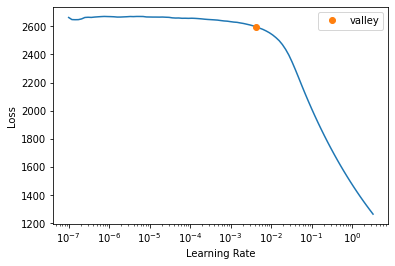

In [ ]:
# Write your code here
learn.lr_find()

### Fit the model

- How many epochs (cycles) are necessary to train the model? Is there a problem with overfitting?

In [ ]:
# Write your answer and code here
# More than 3 rounds/epochs may increase the chances for overfitting
# Trial and error!
learn.fit_one_cycle(10, lr_max=5e-3)

epoch,train_loss,valid_loss,_rmse,mae,time
0,976.220764,211.618927,14.547129,14.274605,00:03
1,24.660976,4.950949,2.225073,1.907999,00:03
2,2.858856,2.151498,1.466799,0.793460,00:03
3,3.418661,2.302856,1.517516,0.821467,00:03
4,2.032350,1.797891,1.340855,0.472832,00:03
5,2.204724,2.030818,1.425067,0.498805,00:03
6,2.275137,2.013614,1.419019,0.474887,00:03
7,1.790094,1.963903,1.401393,0.444983,00:03
8,1.914655,1.731200,1.315751,0.448911,00:03
9,1.984588,1.790447,1.338076,0.464534,00:03


### Evaluate the model

Report the in-sample as well as the out-of-sample performance usinge the mean absolute error.

In [ ]:
# Write your code here
print("in-sample performance: {}".format(np.array(learn.validate(ds_idx=0)[2])))

in-sample performance: 0.4461558163166046


In [ ]:
# Write your code here
print("out-of-sample performance: {}".format(np.array(learn.validate(ds_idx=1)[2])))

out-of-sample performance: 0.4645337760448456


## Discussion

Looking at the results, discuss the advantages and disadvantages of deep learning for tabular data.

In [ ]:
# Write your answer here
# Some points you could have mentioned:

# Advantages
# - does not require feature engineering
# - thus, it can flexibly adapt to new challenges

# Disadvantages
# - often requires large amount of data
# - requires high compiuting power 
# - training ist often time consuming